# 0. Package Import

In [21]:
#Change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import geopy.distance
import seaborn as sns
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import Lasso
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# 1.Data Wrangeling
The imported data was already cleaned from pick- and dropoff that are located on water. The computation was done within a separate project to decrease the computational time here.

In [2]:
#Import the data
uber_raw = pd.read_csv(r"C:\Users\motox\OneDrive\Data Science Coding\Uber Fair Prediction\uber_land_high_accuracy.csv")

#Print out the first 5 rows to take a first look at the data
print(uber_raw.head())

#We can drop the first two columns as they are just personalized customer identifiers and the last two as they are just
uber_dropped = uber_raw.drop(uber_raw.columns[[0, 1, -1, -2]], axis=1)

#See if all columns are in the right format
print(uber_dropped.info())

#The column 'pickup_datetime' is the wrong format
uber_dropped['pickup_datetime'] = pd.to_datetime(uber_dropped['pickup_datetime'], infer_datetime_format=True)

#Check if there any missing values
print(uber_dropped.isna().sum())

#There are missing values so let's drop them
uber_cleaned = uber_dropped.dropna()
print(uber_cleaned.info())

#Print number of duplicates
print('The number of duplicate rows are: ' + str(uber_cleaned.duplicated().sum()))

   Unnamed: 0                            key  fare_amount  \
0    24238194    2015-05-07 19:52:06.0000003          7.5   
1    27835199    2009-07-17 20:04:56.0000002          7.7   
2    44984355   2009-08-24 21:45:00.00000061         12.9   
3    25894730    2009-06-26 08:22:21.0000001          5.3   
4    17610152  2014-08-28 17:47:00.000000188         16.0   

           pickup_datetime  pickup_longitude  pickup_latitude  \
0  2015-05-07 19:52:06 UTC        -73.999817        40.738354   
1  2009-07-17 20:04:56 UTC        -73.994355        40.728225   
2  2009-08-24 21:45:00 UTC        -74.005043        40.740770   
3  2009-06-26 08:22:21 UTC        -73.976124        40.790844   
4  2014-08-28 17:47:00 UTC        -73.925023        40.744085   

   dropoff_longitude  dropoff_latitude  passenger_count  pickup_on_land  \
0         -73.999512         40.723217                1            True   
1         -73.994710         40.750325                1            True   
2         -73.962

# Generating additional data

In [3]:
#Since only longitude and latitude data was orginally provided we will generate the starting and ending corrdinates and add them to the DataFrame
uber_cleaned['starting coordinates'] = list(zip(uber_cleaned['pickup_latitude'], uber_cleaned['pickup_longitude']))
uber_cleaned['ending coordinates'] = list(zip(uber_cleaned['dropoff_latitude'], uber_cleaned['dropoff_longitude']))

#Generate column of distance
uber_cleaned['distance in km'] = [geopy.distance.distance(uber_cleaned['starting coordinates'][i],uber_cleaned['ending coordinates'][i]).km for i in uber_cleaned.index]

#Since the Taxi fares are generally time dependant and differ strongly through hours and days we will extract that information out of the 'pickup_datetime'-column
uber_cleaned['year'] = uber_cleaned['pickup_datetime'].dt.year
uber_cleaned['month'] = uber_cleaned['pickup_datetime'].dt.month
uber_cleaned['day'] = uber_cleaned['pickup_datetime'].dt.day
uber_cleaned['hour'] = uber_cleaned['pickup_datetime'].dt.hour
uber_cleaned['weekday'] = uber_cleaned['pickup_datetime'].dt.dayofweek.replace([0, 1, 2, 3, 4, 5, 6],
                                                                               ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

#Dropping all columns that won't be used for modeling
uber_cleaned.drop(['pickup_datetime', 'starting coordinates', 'ending coordinates'], axis=1, inplace=True)

# Identifying outliers and deleting them from the data set
The detection and cleaning of outliers will be done via the inter-quartile-range(IQR) method.

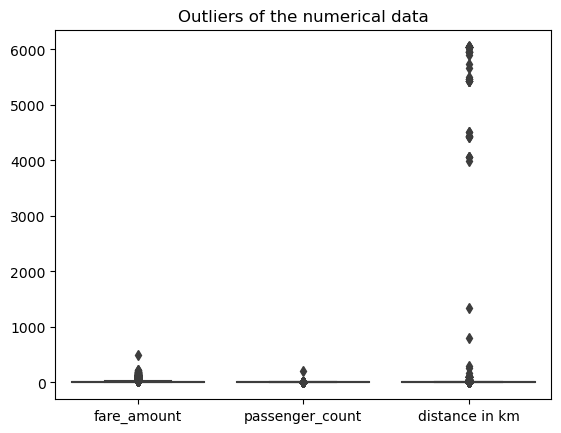

In [4]:
#The lower limit for 'fare_amount' is 2.5$, for 'passenger_count' 1 and distance 0
uber_cleaned = uber_cleaned[(uber_cleaned['fare_amount'] >= 2.5) & (uber_cleaned['passenger_count'] >= 1) & (uber_cleaned['distance in km'] > 0)]

#Identifying columns that have to be cleaned
outlier_columns = ['fare_amount', 'passenger_count', 'distance in km']

#Printing the boxplot to get a visual idea about the data
sns.boxplot(data=uber_cleaned[outlier_columns]).set(title='Outliers of the numerical data')
plt.show()

As we can see now there is a fair amount of outliers with partly extreme values. We will now get rid of those.

0.9152697801184451


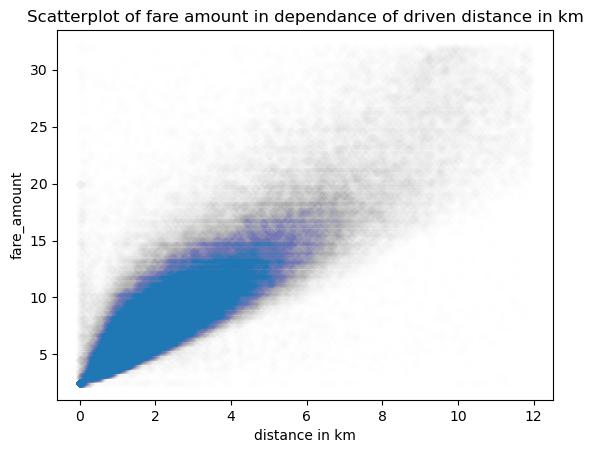

In [5]:
#Defining the for loop that checks for outliers
upper_limits = []

for i in outlier_columns:
    upper_limits.append(np.percentile(uber_cleaned[i], 75)+3*(np.percentile(uber_cleaned[i], 75) - np.percentile(uber_cleaned[i], 25)))
uber_cleaned = uber_cleaned[(uber_cleaned[outlier_columns[0]] <= upper_limits[0]) &
                            (uber_cleaned[outlier_columns[1]] <= upper_limits[1]) &
                            (uber_cleaned[outlier_columns[2]] <= upper_limits[2])]

#Printing out the proportion of the orginal data that is now left  after cleaning
print(len(uber_cleaned)/len(uber_raw))

#Printing out the scatter plot
sns.scatterplot(data=uber_cleaned, x='distance in km', y='fare_amount', alpha=0.002).set(title='Scatterplot of fare amount in dependance of driven distance in km')
plt.show()

As we can see now the data approximately follows a linear distribution and distance will prospectively be a good predictor for fare amount

# Visualizing the pickup and dropoff locations on a world map

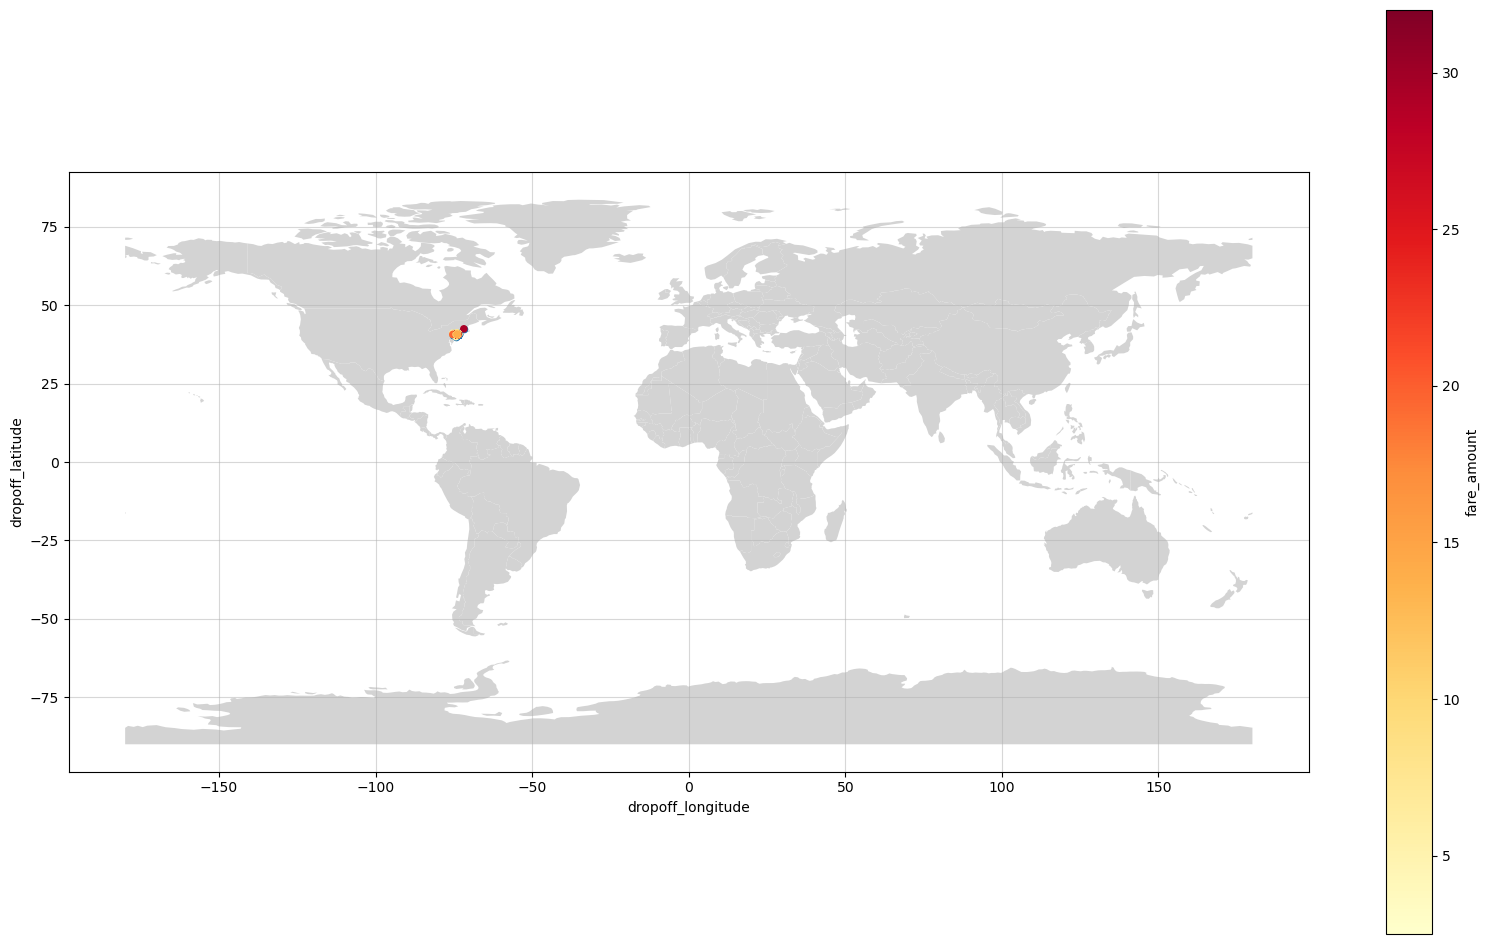

In [6]:
# initialize an axis
fig, ax = plt.subplots(figsize=(20,12))
# plot map on axis
countries = gpd.read_file(  
     gpd.datasets.get_path("naturalearth_lowres"))
countries.plot(color="lightgrey", ax=ax)
# plot points
uber_cleaned.plot(x="pickup_longitude", y="pickup_latitude", kind="scatter", ax=ax)
uber_cleaned.plot(x="dropoff_longitude", y="dropoff_latitude", kind="scatter", colormap="YlOrRd", c='fare_amount', ax=ax)
# add grid
ax.grid(b=True, alpha=0.5)
plt.show()

The uber rides seems to be located in and around New York City, which wasn't obvious before data cleaning.

# Preprocessing of numerical and categorical data

In [7]:
#Now separate target data 'y',which we want to predict, and feature data X into separate DataFrames 
y = uber_cleaned['fare_amount']

X = uber_cleaned.drop('fare_amount', axis=1)

#We are going to use the sklearn 'make_column_selector' to split the data into categorical and numerical data
#Initiate the selector
num_cols_selector = selector(dtype_exclude=object)
cat_cols_selector = selector(dtype_include=object)

#Split the data
num_col = num_cols_selector(X)
cat_col = cat_cols_selector(X)

#Assign columns to a specific processor. 'One-Hot-Encoding' will be used on categorical data and scaling on numerical data
cat_preprocessor = OneHotEncoder(handle_unknown="ignore")
num_preprocessor = StandardScaler()

#Now associate each of these preprocessors with their respective columns using the 'ColumnTransformer' package
preprocessor = ColumnTransformer([('one-hot-encoder', cat_preprocessor, cat_col),
                                  ('standard_scaler', num_preprocessor, num_col)])

# Split the data into train and test data

In [8]:
#Initiate the 'train_test_split'-package
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42069)

#Ininitialize KFold for cross validation of the model to prevent overfitting
kf = KFold(n_splits=6, shuffle=True, random_state=42)

# Initiating several regression models
To make sure that the model's best version is used, we will optimize the hyperparameters by using the package GridSearchCV.

First we are going to define an empty dictionary which will be filled with the selected models.

In [9]:
#Initiate an empty dictionary later containing the models
models = {}

In [10]:
#Linear Lasso Regression
#Define the steps of the pipeline
lasso_steps = [('preprocessor', preprocessor), ('lasso', Lasso(max_iter=1000))]

#Initialize the pipeline
lasso_pipeline = Pipeline(lasso_steps)

#Define dictionary of lists of hyperparameters to test out
lasso_parameters = {'lasso__alpha':[0.0001,0.001, 0.01, 0.1, 1]}

#Initialize the model
models['Lasso'] = GridSearchCV(lasso_pipeline, param_grid=lasso_parameters, cv=kf, scoring='r2', n_jobs=-1)

In [11]:
#SGD Regressor
#Define the steps of the pipeline
sgd_steps = [('preprocessor', preprocessor), ('sgd', SGDRegressor(max_iter=1000))]

#Initialize the pipeline
sgd_pipeline = Pipeline(sgd_steps)

#Define dictionary of lists of hyperparameters to test out
sgd_parameters = {'sgd__penalty':['l1','l2', 'elasticnet']}

#Initialize the model
models['SGD Regressor'] = GridSearchCV(sgd_pipeline, param_grid=sgd_parameters, cv=kf, scoring='r2', n_jobs=-1)

In [12]:
#Gradient Boosting Regressor
#Define the steps of the pipeline
gradient_steps = [('preprocessor', preprocessor), ('gradient', GradientBoostingRegressor(n_estimators=300))]

#Initialize the pipeline
gradient_pipeline = Pipeline(gradient_steps)

#Define dictionary of lists of hyperparameters to test out
gradient_parameters = {'gradient__max_depth':list(range(1, 11))}

#Initialize the model
models['Gradient Boosting Regressor'] = GridSearchCV(gradient_pipeline, param_grid=gradient_parameters, cv=kf, scoring='r2', n_jobs=-1)

In [13]:
#Support Vector Regression
#Define the steps of the pipeline
svr_steps = [('preprocessor', preprocessor), ('svr', SVR())]

#Initialize the pipeline
svr_pipeline = Pipeline(svr_steps)

#Define dictionary of lists of hyperparameters to test out
svr_parameters = {'svr__kernel':['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']}

#Initialize the model
models['Support Vector Regression'] = GridSearchCV(svr_pipeline, param_grid=svr_parameters, cv=kf, scoring='r2', n_jobs=-1)

# Fitting the models to the train data and calculating their respective scoring metrics

In [14]:
#Initiating the scoring dictionaries
cv, r2, mse, rmse, mae = {}, {}, {}, {}, {}

#Fit all models separately and populate the scoring metrics
for key in models.keys():
    
    #Fit the classifier model
    models[key].fit(X_train, y_train)
    #Prediction
    predictions = models[key].best_estimator_.predict(X_test)
        
    #Calculate CV-Score, Accuracy, Precision, Recall and ROC-AUC-Score metrics
    cv[key] = cross_val_score(models[key].best_estimator_, X_train, y_train, cv=kf).mean()
    r2[key] = r2_score(y_test, predictions)
    mse[key] = mean_squared_error(y_test, predictions, squared=True)
    rmse[key] = mean_squared_error(y_test, predictions, squared=False)
    mae[key] = mean_absolute_error(y_test, predictions)

In [15]:
#Putting all scoring metrics into a DataFrame
df_model = pd.DataFrame(index=models.keys(), columns=['CV-Score','R2-Score', 'MSE', 'RMSE', 'MAE'])
df_model['CV-Score'] = cv.values()
df_model['R2-Score'] = r2.values()
df_model['MSE'] = mse.values()
df_model['RMSE'] = rmse.values()
df_model['MAE'] = mae.values()
df_model

,CV-Score,R2-Score,MSE,RMSE,MAE
Lasso,0.762245,0.761381,6.510437,2.551556,1.724641
SGD Regressor,0.761863,0.760789,6.526595,2.554720,1.734237
Gradient Boosting Regressor,0.840796,0.844497,4.242721,2.059787,1.298534
Support Vector Regression,0.813401,0.814884,5.050679,2.247371,1.382670


The model with the best results seems to be the Gradient Boosting Regressor.

# Plotting the feature importance
We will now calculate the feature importance via permutation importance. Here each feature is permutated or resampled while the remaining features stay as they are. This obscures the predictive value of that feature and the loss of accuracy of target prediction is plotted. In this example we will use the Gradient Boosting Model, as that seems to have the most consistent scores across all scoring metrics.

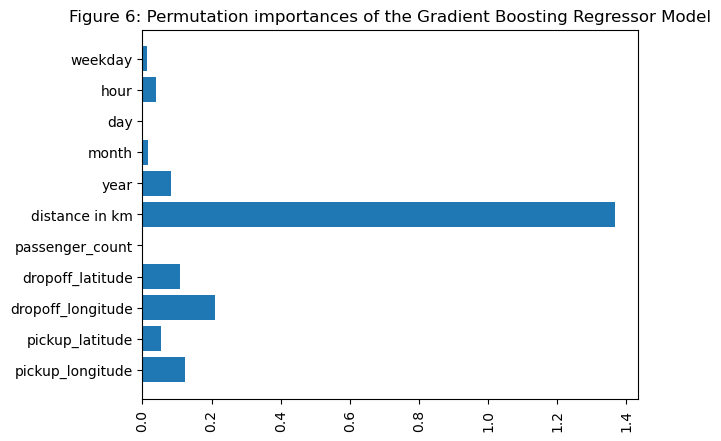

In [28]:
#Now the permutation importances will be calculated
results = permutation_importance(models['Gradient Boosting Regressor'].best_estimator_, X_test, y_test, scoring='r2')
importance = abs(results.importances_mean)

#Bar plot of the feature importances
plt.barh(X.columns, importance)
plt.title('Figure 6: Permutation importances of the Gradient Boosting Regressor Model', y=1.0)
plt.xticks(rotation=90)
plt.yticks(fontsize=10)
plt.show()

Like predicted the distance column seems to be the strongest predictor of fare amount, whereas the other features have significantly less impact on outcome. Knowing that the utilisation of PCA-Transformation would have been an effective tool in decreasing computation time.